In [ ]:
# ======= Variables =========

# Fill in the variables below and run cell first
# Note: Use forward slashes / instead of backslashes \ in file paths

DATASET_FOR_MODEL_CSV_FILE_PATH = 'C:/cal-housing-prices/dataset/dataset.csv'

TRAINING_SET_CSV_FILE_PATH = 'C:/cal-housing-prices/dataset/training_set.csv'
TEST_SET_CSV_FILE_PATH = 'C:/cal-housing-prices/dataset/test_set.csv'
TEST_SET_SIZE = 0.1  # fraction of the dataset to be used as test set

RANDOM_SEED = 123


In [107]:
# ========= Libraries =========

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset

## ML

In [108]:
# ========= CustomDataset class =========

torch.manual_seed(RANDOM_SEED)  # Set the random seed in PyTorch for reproducibility

class CustomDataset(Dataset):
    """
    A custom dataset class for handling data directly from a pandas dataframe.

    """
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Assuming the last column is the output/target
        data = torch.tensor(row[:-1].values, dtype=torch.float32)
        target = torch.tensor(row[-1], dtype=torch.float32)
        return data, target


In [109]:
# ========= Create Training and Test sets =========

# Load dataset into a pandas DataFrame
df = pd.read_csv(DATASET_FOR_MODEL_CSV_FILE_PATH)

# Separate a Test set and keep it aside
dfTest = df.sample(frac=TEST_SET_SIZE, axis='index', random_state=RANDOM_SEED) # random_state parameter is included for reproducibility
df = df.drop(dfTest.index) # the remaining data is used as the training set

# Save the Training and Test sets to CSV files
df.to_csv(TRAINING_SET_CSV_FILE_PATH, index=False)
dfTest.to_csv(TEST_SET_CSV_FILE_PATH, index=False)

In [110]:
# ========= Neural Network and Training classes =========

class SimpleNN(torch.nn.Module):
    def __init__(self, input_size=3, output_size=1, neurons=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, neurons)
        # self.fc1a = torch.nn.Linear(neurons, neurons) # add another layer
        # self.fc1b = torch.nn.Linear(neurons, neurons) # add another layer
        self.fc2 = torch.nn.Linear(neurons, output_size)

    def forward(self, x):
        # print("input: ", x.shape)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # x = self.fc1a(x)  # add another layer
        # x = torch.nn.functional.relu(x) 
        # x = self.fc1b(x)  # add another layer
        # x = torch.nn.functional.relu(x) 
        x = self.fc2(x)
        # print("output: ", x.shape)
        return x
    
class NeuralNetworkRegressor:
    def __init__(self, input_size=5, output_size=1, neurons=10, learning_rate=0.001, batch_size=32, epochs=100):
        self.norm_params = {}
        self.model = SimpleNN(input_size=input_size, output_size=output_size, neurons=neurons)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device("cpu")
        self.model.to(self.device)
        self.loss_function = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    def normalize(self, dataframe, train=False):
        for column in dataframe.columns:
            # Mean 0, Standard Deviation 1 Normalization
            mean = dataframe[column].mean() if train else self.norm_params[column][0]
            std = dataframe[column].std() if train else self.norm_params[column][1]
            standardized_data = (dataframe[column] - mean) / std

            # Min-Max Normalization
            min_value = standardized_data.min() if train else self.norm_params[column][2]
            max_value = standardized_data.max() if train else self.norm_params[column][3]

            if train:
                self.norm_params[column] = (mean, std, min_value, max_value)
            dataframe[column] = (standardized_data - min_value) / (max_value - min_value)
        return dataframe
    
    def denormalize(self, dataframe):
        for column in dataframe.columns:
             # Retrieve normalization parameters
            mean, std, min_value, max_value = self.norm_params[column] 

            # Min-Max De-normalization
            dataframe[column] = dataframe[column] * (max_value - min_value) + min_value

            # Mean 0, Standard Deviation 1 De-normalization
            dataframe[column] = dataframe[column] * std + mean
        return dataframe

    def train(self, dataframe):

        dataframe = self.normalize(dataframe.copy(), train=True)
        dataset = CustomDataset(dataframe)
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0

            for data, target in train_loader:

                data, target = data.to(self.device), target.to(self.device)
                # print(data.shape, target.shape)
                
                self.model.zero_grad()
                output = self.model(data)
                loss = self.loss_function(output, target.view(-1, 1))
                
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()

            print(f"Epoch: {epoch + 1}, Loss: {total_loss}")

    def predict(self, dataframe):
        # assume the last column in the dataframe is the target initialized to 0 and will be replaced by the prediction
        dataframe = self.normalize(dataframe, train=False)
        dataset = CustomDataset(dataframe)

        self.model.eval()

        for i in range(len(dataset)):
            data, _ = dataset[i]
            data = data.to(self.device)
            output = self.model(data)
            dataframe.iloc[i, -1] = output.item()

        dataframe = self.denormalize(dataframe)
        return dataframe
    

## Train Model

In [111]:
# ========= Load Training and Test sets =========

# Load the Training set into a pandas dataframe
dfTraining = pd.read_csv(TRAINING_SET_CSV_FILE_PATH)

# Load the Test set into a pandas dataframe
dfTest = pd.read_csv(TEST_SET_CSV_FILE_PATH)



In [ ]:
# ========= Training =========

model = NeuralNetworkRegressor(input_size=6, output_size=1, neurons=100, learning_rate=0.001, batch_size=100, epochs=25)

model.train(dfTraining)

C:\Users\stavr\AppData\Local\Temp\ipykernel_67784\432725770.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = torch.tensor(row[-1], dtype=torch.float32)


Epoch: 1, Loss: 6.090470829978585
Epoch: 2, Loss: 3.042125646956265
Epoch: 3, Loss: 2.833784144371748
Epoch: 4, Loss: 2.797670168802142
Epoch: 5, Loss: 2.7553047677502036
Epoch: 6, Loss: 2.726537933573127
Epoch: 7, Loss: 2.701164443977177
Epoch: 8, Loss: 2.6618588445708156
Epoch: 9, Loss: 2.6487461901269853
Epoch: 10, Loss: 2.6202637553215027
Epoch: 11, Loss: 2.5878603886812925
Epoch: 12, Loss: 2.5807483717799187
Epoch: 13, Loss: 2.575589632615447
Epoch: 14, Loss: 2.537555775605142
Epoch: 15, Loss: 2.5316489385440946
Epoch: 16, Loss: 2.5130460234358907
Epoch: 17, Loss: 2.5059470031410456
Epoch: 18, Loss: 2.5115236211568117
Epoch: 19, Loss: 2.4785198443569243
Epoch: 20, Loss: 2.4999280190095305
Epoch: 21, Loss: 2.479034219868481
Epoch: 22, Loss: 2.4635283444076777
Epoch: 23, Loss: 2.451043063774705
Epoch: 24, Loss: 2.4545127814635634
Epoch: 25, Loss: 2.4418517723679543
Epoch: 26, Loss: 2.4346506372094154
Epoch: 27, Loss: 2.4309089072048664
Epoch: 28, Loss: 2.4321584925055504
Epoch: 29, 

## Training Set Prediction

C:\Users\stavr\AppData\Local\Temp\ipykernel_67784\432725770.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = torch.tensor(row[-1], dtype=torch.float32)


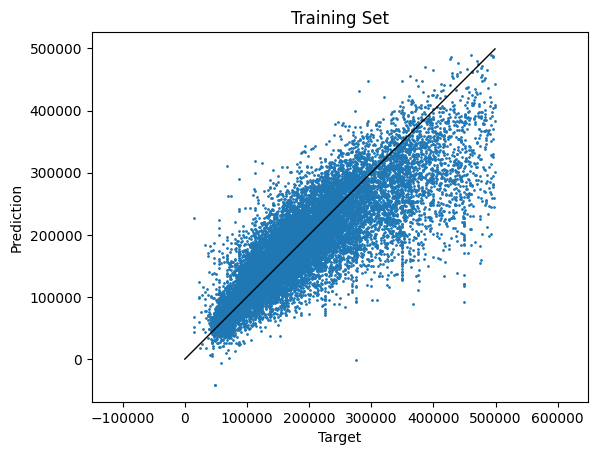

In [113]:
import matplotlib.pyplot as plt

# make a copy of dfTraining to keep the original data
dfPredict = dfTraining.copy()

model.predict(dfPredict)

# plot the test target vs prediction in scatter plot. also plot the y = x line
plt.scatter(dfTraining.iloc[:,-1], dfPredict.iloc[:,-1], s=1, marker='o')
plt.plot([0, dfTraining.iloc[:,-1].max()], [0, dfTraining.iloc[:,-1].max()], color='black', linewidth=1)
plt.axis('equal')  # Make the axes have the same scale
plt.title("Training Set")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

## Test Set Prediction

C:\Users\stavr\AppData\Local\Temp\ipykernel_67784\432725770.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = torch.tensor(row[-1], dtype=torch.float32)


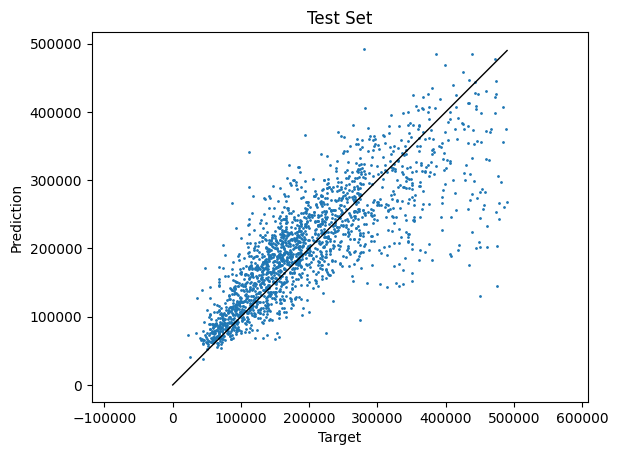

In [88]:
import matplotlib.pyplot as plt

# make a copy of dfTest to keep the original data
dfTestPredict = dfTest.copy()

model.predict(dfTestPredict)

# plot the test target vs prediction in scatter plot. also plot the y = x line
plt.scatter(dfTest.iloc[:,-1], dfTestPredict.iloc[:,-1], s=1, marker='o')
plt.plot([0, dfTest.iloc[:,-1].max()], [0, dfTest.iloc[:,-1].max()], color='black', linewidth=1)
# plt.xlim(left=0)
# plt.ylim(bottom=0) 
plt.axis('equal')  # Make the axes have the same scale
plt.title("Test Set")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

In [76]:
dfTraining

,longitude,latitude,housing_median_age,households,median_income,median_house_value
0,-122.23,37.88,41.0,126.0,83252.0,452600.0
1,-122.22,37.86,21.0,1138.0,83014.0,358500.0
2,-122.24,37.85,52.0,177.0,72574.0,352100.0
3,-122.25,37.85,52.0,219.0,56431.0,341300.0
4,-122.25,37.85,52.0,259.0,38462.0,342200.0
...,...,...,...,...,...,...
18378,-121.09,39.48,25.0,330.0,15603.0,78100.0
18379,-121.21,39.49,18.0,114.0,25568.0,77100.0
18380,-121.22,39.43,17.0,433.0,17000.0,92300.0
18381,-121.32,39.43,18.0,349.0,18672.0,84700.0
